In [1]:
import os
import pandas as pd

data = pd.read_csv('labels/Data_Entry_2017_v2020.csv')
data = data.rename(columns={'Finding Label': 'Finding Labels'})


exclude_labels = [
    'Hernia', 'Pneumonia', 'Edema', 'Cardiomegaly', 'Consolidation', 
    'Pleural_Thickening', 'Fibrosis', 'Emphysema', 'Pneumothorax', 
    'Mass', 'No Finding'
]

filtered_data = data[~data['Finding Labels'].str.contains('|'.join(exclude_labels), na=False)]
filtered_data = filtered_data[~filtered_data['Finding Labels'].str.contains(r'\|', na=False)]


filtered_data = filtered_data[['Image Index', 'Finding Labels']]


base_dir = 'xray_data'


def find_image_path(image_index, base_dir):
   
    for subfolder in sorted(os.listdir(base_dir)): 
        subfolder_path = os.path.join(base_dir, subfolder)
        nested_images_path = os.path.join(subfolder_path, 'images')

        if os.path.isdir(nested_images_path):
            image_path = os.path.join(nested_images_path, image_index)
            if os.path.exists(image_path): 
                return image_path

    return None

filtered_data['Image Path'] = filtered_data['Image Index'].apply(lambda x: find_image_path(x, base_dir))


num_invalid = filtered_data['Image Path'].isna().sum()
num_valid = filtered_data['Image Path'].notna().sum()
print(f"Number of invalid paths: {num_invalid}")
print(f"Number of valid paths: {num_valid}")


filtered_data = filtered_data.dropna(subset=['Image Path']).reset_index(drop=True)


print(filtered_data.head())


Number of invalid paths: 0
Number of valid paths: 20422
        Image Index Finding Labels  \
0  00000005_006.png   Infiltration   
1  00000008_002.png         Nodule   
2  00000010_000.png   Infiltration   
3  00000011_000.png       Effusion   
4  00000011_005.png   Infiltration   

                                     Image Path  
0  xray_data/images_001/images/00000005_006.png  
1  xray_data/images_001/images/00000008_002.png  
2  xray_data/images_001/images/00000010_000.png  
3  xray_data/images_001/images/00000011_000.png  
4  xray_data/images_001/images/00000011_005.png  


In [108]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from collections import Counter

class ChestXRayDataset(Dataset):
    def __init__(self,label_to_index, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row['Image Path']
        label = row['Finding Labels']
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        label = label_to_index[label]
        return image, label


unique_labels = filtered_data['Finding Labels'].unique()
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}


train_df, temp_data = train_test_split(
    filtered_data, 
    test_size=0.20,  
    random_state=42, 
    stratify=filtered_data['Finding Labels']  
)

valid_df, test_data = train_test_split(
    temp_data, 
    test_size=0.50,  
    random_state=42, 
    stratify=temp_data['Finding Labels']  
)

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),          
    transforms.RandomHorizontalFlip(p=0.2), 
    #transforms.RandomVerticalFlip(p=0.1),  
    #transforms.RandomRotation(30),         
    #transforms.ColorJitter(brightness=0.2,
    transforms.ToTensor(),                   
    transforms.Normalize(mean=[0.4972, 0.4972, 0.4972], std=[0.2473, 0.2473, 0.2473]) 
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4972, 0.4972, 0.4972], std=[0.2473, 0.2473, 0.2473]) 
])

print("Training set distribution:")
print(train_df['Finding Labels'].value_counts())




Training set distribution:
Infiltration    7637
Atelectasis     3372
Effusion        3164
Nodule          2164
Name: Finding Labels, dtype: int64


In [76]:

train_dataset = ChestXRayDataset(label_to_index,train_df, transform=train_transform)
val_dataset = ChestXRayDataset(label_to_index,valid_df, transform=val_transform)
test_dataset = ChestXRayDataset(label_to_index,test_data, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4,pin_memory=True)

In [77]:
import torch.nn as nn
import torch.nn.functional as F


class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, num_classes=4, dropout_rate=0.5):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        self.dropout_rate = dropout_rate
        
        self.init_conv = nn.Sequential(
        nn.Conv2d(3, growth_rate * 2, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(growth_rate * 2), 
        nn.ReLU(inplace=True))
        
        self.init_pool = nn.MaxPool2d(3, stride=2, padding=1)
        
        self.block1 = DenseBlock(growth_rate * 2, growth_rate, 6)
        self.trans1 = TransitionLayer(growth_rate * 8, growth_rate * 4)
        
        self.block2 = DenseBlock(growth_rate * 4, growth_rate, 12)
        self.trans2 = TransitionLayer(growth_rate * 16, growth_rate * 8)
        
        self.block3 = DenseBlock(growth_rate * 8, growth_rate, 24)
        self.trans3 = TransitionLayer(growth_rate * 32, growth_rate * 16)
        
        self.block4 = DenseBlock(growth_rate * 16, growth_rate, 16)
        self.classifier = nn.Linear(growth_rate * 16 + growth_rate * 16, num_classes)

    def forward(self, x):
        x = self.init_conv(x)
        x = self.init_pool(x)

        x = self.block1(x)
        x = self.trans1(x)

        x = self.block2(x)
        x = self.trans2(x)

        x = self.block3(x)
        x = self.trans3(x)

        x = self.block4(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


model = DenseNet(growth_rate=16, num_classes=4, dropout_rate=0.2)


In [91]:
import torch.nn as nn
from torchvision import models

model = models.densenet121(weights=DenseNet121_Weights.DEFAULT.)

num_classes = len(unique_labels)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [92]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [93]:
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    print(f"Epoch {epoch+1}/{epochs}")
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct / total
    print(f"Train Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")
    train_loss = running_loss/len(train_loader)

    return train_accuracy, train_loss

def val_one_epoch(model, val_loader, criterion, optimizer):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct / total
    validation_loss = val_loss/len(val_loader)
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    return validation_loss, val_accuracy

    

In [94]:
import torch.optim as optim
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

epochs = 20

avg_train_loss = []
avg_train_acc = []
avg_val_loss = []
avg_val_acc = []
for epoch in range(epochs):
    train_accuracy, train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
    avg_train_loss.append(train_loss)
    avg_train_acc.append(train_accuracy)
    
    validation_loss, val_accuracy = val_one_epoch(model, val_loader, criterion, optimizer)
    avg_val_loss.append(validation_loss)
    avg_val_acc.append(val_accuracy)
    


Epoch 1/20


Training: 100%|██████████| 511/511 [01:18<00:00,  6.50it/s]


Train Loss: 1.1747, Train Accuracy: 50.00%


Validation: 100%|██████████| 64/64 [00:10<00:00,  6.18it/s]


Validation Loss: 1.0809, Validation Accuracy: 54.41%
Epoch 2/20


Training: 100%|██████████| 511/511 [01:18<00:00,  6.47it/s]


Train Loss: 1.0880, Train Accuracy: 55.35%


Validation: 100%|██████████| 64/64 [00:10<00:00,  6.16it/s]


Validation Loss: 1.0716, Validation Accuracy: 55.68%
Epoch 3/20


Training: 100%|██████████| 511/511 [01:18<00:00,  6.50it/s]


Train Loss: 1.0518, Train Accuracy: 56.74%


Validation: 100%|██████████| 64/64 [00:10<00:00,  6.23it/s]


Validation Loss: 1.1054, Validation Accuracy: 53.23%
Epoch 4/20


Training: 100%|██████████| 511/511 [01:18<00:00,  6.49it/s]


Train Loss: 1.0327, Train Accuracy: 57.45%


Validation: 100%|██████████| 64/64 [00:10<00:00,  6.19it/s]


Validation Loss: 1.0338, Validation Accuracy: 57.64%
Epoch 5/20


Training: 100%|██████████| 511/511 [01:18<00:00,  6.53it/s]


Train Loss: 1.0141, Train Accuracy: 58.54%


Validation: 100%|██████████| 64/64 [00:10<00:00,  6.23it/s]


Validation Loss: 1.0196, Validation Accuracy: 59.30%
Epoch 6/20


Training: 100%|██████████| 511/511 [01:18<00:00,  6.50it/s]


Train Loss: 1.0045, Train Accuracy: 58.81%


Validation: 100%|██████████| 64/64 [00:10<00:00,  6.11it/s]


Validation Loss: 1.0202, Validation Accuracy: 60.53%
Epoch 7/20


Training: 100%|██████████| 511/511 [01:18<00:00,  6.51it/s]


Train Loss: 0.9904, Train Accuracy: 58.93%


Validation: 100%|██████████| 64/64 [00:10<00:00,  6.19it/s]


Validation Loss: 1.0219, Validation Accuracy: 57.25%
Epoch 8/20


Training: 100%|██████████| 511/511 [01:18<00:00,  6.47it/s]


Train Loss: 0.9714, Train Accuracy: 60.35%


Validation: 100%|██████████| 64/64 [00:10<00:00,  6.22it/s]


Validation Loss: 1.2530, Validation Accuracy: 44.12%
Epoch 9/20


Training: 100%|██████████| 511/511 [01:19<00:00,  6.45it/s]


Train Loss: 0.9605, Train Accuracy: 60.97%


Validation: 100%|██████████| 64/64 [00:10<00:00,  6.13it/s]


Validation Loss: 1.0024, Validation Accuracy: 60.14%
Epoch 10/20


Training: 100%|██████████| 511/511 [01:19<00:00,  6.46it/s]


Train Loss: 0.9464, Train Accuracy: 61.66%


Validation: 100%|██████████| 64/64 [00:10<00:00,  6.26it/s]


Validation Loss: 1.1249, Validation Accuracy: 53.38%
Epoch 11/20


Training: 100%|██████████| 511/511 [01:18<00:00,  6.49it/s]


Train Loss: 0.9388, Train Accuracy: 62.26%


Validation: 100%|██████████| 64/64 [00:10<00:00,  6.17it/s]


Validation Loss: 0.9684, Validation Accuracy: 62.29%
Epoch 12/20


Training: 100%|██████████| 511/511 [01:19<00:00,  6.46it/s]


Train Loss: 0.9254, Train Accuracy: 62.61%


Validation: 100%|██████████| 64/64 [00:10<00:00,  6.20it/s]


Validation Loss: 0.9688, Validation Accuracy: 60.72%
Epoch 13/20


Training: 100%|██████████| 511/511 [01:18<00:00,  6.48it/s]


Train Loss: 0.9133, Train Accuracy: 63.22%


Validation: 100%|██████████| 64/64 [00:10<00:00,  6.20it/s]


Validation Loss: 1.0002, Validation Accuracy: 59.99%
Epoch 14/20


Training: 100%|██████████| 511/511 [01:19<00:00,  6.47it/s]


Train Loss: 0.9038, Train Accuracy: 64.24%


Validation: 100%|██████████| 64/64 [00:10<00:00,  6.22it/s]


Validation Loss: 0.9697, Validation Accuracy: 62.14%
Epoch 15/20


Training: 100%|██████████| 511/511 [01:19<00:00,  6.46it/s]


Train Loss: 0.8880, Train Accuracy: 64.30%


Validation: 100%|██████████| 64/64 [00:10<00:00,  6.25it/s]


Validation Loss: 0.9546, Validation Accuracy: 62.29%
Epoch 16/20


Training: 100%|██████████| 511/511 [01:18<00:00,  6.49it/s]


Train Loss: 0.8712, Train Accuracy: 65.33%


Validation: 100%|██████████| 64/64 [00:10<00:00,  6.23it/s]


Validation Loss: 0.9828, Validation Accuracy: 60.68%
Epoch 17/20


Training: 100%|██████████| 511/511 [01:18<00:00,  6.50it/s]


Train Loss: 0.8606, Train Accuracy: 65.68%


Validation: 100%|██████████| 64/64 [00:10<00:00,  6.24it/s]


Validation Loss: 0.9960, Validation Accuracy: 61.02%
Epoch 18/20


Training: 100%|██████████| 511/511 [01:18<00:00,  6.49it/s]


Train Loss: 0.8555, Train Accuracy: 66.38%


Validation: 100%|██████████| 64/64 [00:10<00:00,  6.25it/s]


Validation Loss: 0.9535, Validation Accuracy: 62.54%
Epoch 19/20


Training: 100%|██████████| 511/511 [01:18<00:00,  6.52it/s]


Train Loss: 0.8381, Train Accuracy: 66.75%


Validation: 100%|██████████| 64/64 [00:10<00:00,  6.23it/s]


Validation Loss: 1.0519, Validation Accuracy: 59.84%
Epoch 20/20


Training: 100%|██████████| 511/511 [01:18<00:00,  6.51it/s]


Train Loss: 0.8348, Train Accuracy: 67.00%


Validation: 100%|██████████| 64/64 [00:10<00:00,  6.21it/s]

Validation Loss: 0.9719, Validation Accuracy: 62.59%


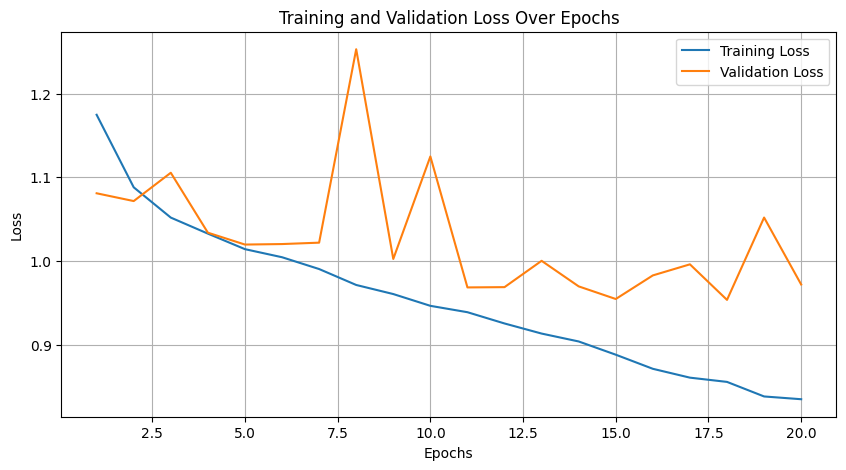

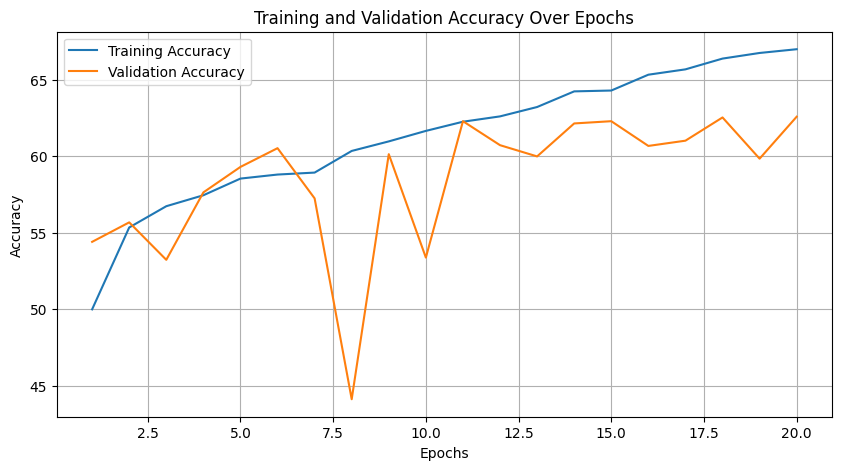

In [95]:
import matplotlib.pyplot as plt
num_epochs = epochs
epochs = range(1, 20 + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, avg_train_loss, label='Training Loss')
plt.plot(epochs, avg_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)


plt.savefig('results_densenet/densenet_loss.png', dpi=300) 
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, avg_train_acc, label='Training Accuracy')
plt.plot(epochs, avg_val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)

plt.savefig('results_densenet/densenet_accuracy.png', dpi=300) 
plt.show()


In [96]:
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

evaluate_model(model, test_loader)


Test Accuracy: 62.70%


In [97]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, roc_auc_score
all_preds = []
all_labels = []
all_probs = [] 

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)  
        all_probs.extend(probabilities.cpu().numpy())
       
        _, predicted = torch.max(outputs, 1)  
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


all_probs = np.array(all_probs) 
all_labels = np.array(all_labels) 
class_names = list(label_to_index.keys())
report = classification_report(all_labels, all_preds, target_names=class_names)


print("\nClassification Report:")
print(report)



Classification Report:
              precision    recall  f1-score   support

Infiltration       0.61      0.88      0.72       955
      Nodule       0.81      0.13      0.22       270
    Effusion       0.69      0.62      0.65       396
 Atelectasis       0.61      0.39      0.48       422

    accuracy                           0.63      2043
   macro avg       0.68      0.50      0.52      2043
weighted avg       0.65      0.63      0.59      2043



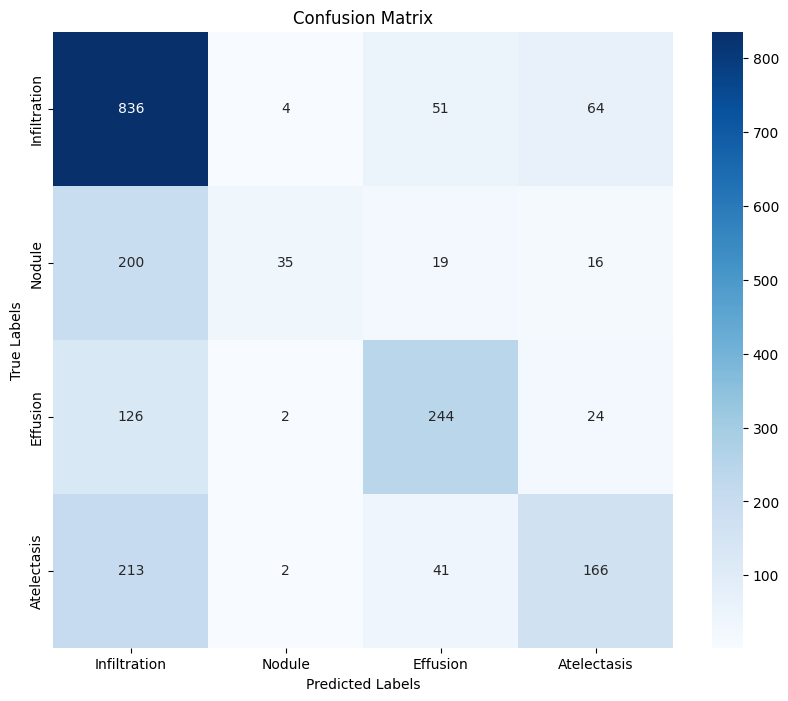

In [98]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('results_densenet/densenet_cm.png')
plt.show()

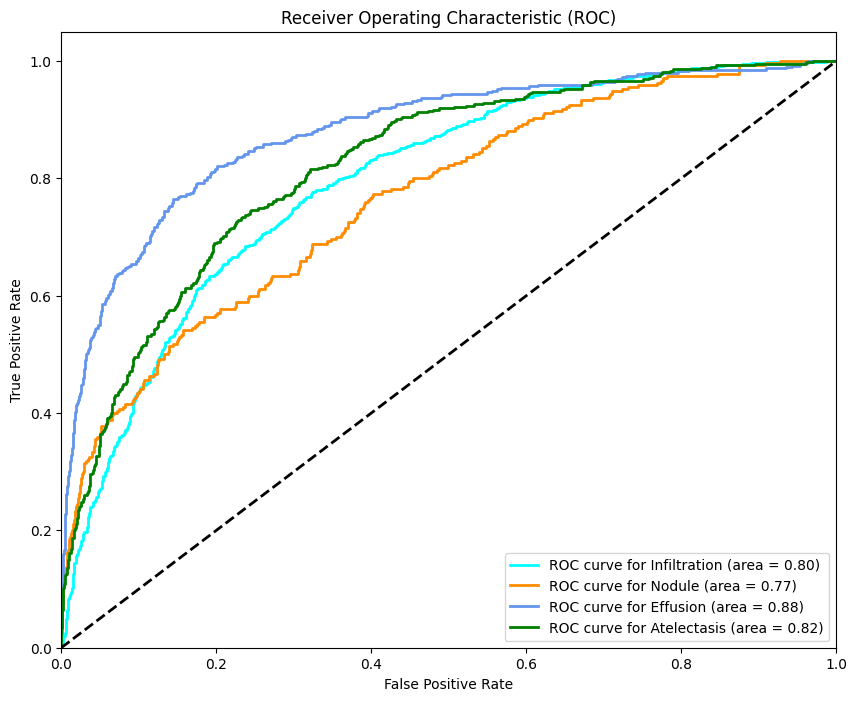

AUC Scores:
Infiltration: 0.80
Nodule: 0.77
Effusion: 0.88
Atelectasis: 0.82


In [99]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np
from sklearn.preprocessing import label_binarize


n_classes = len(class_names)
all_labels_one_hot = label_binarize(all_labels, classes=np.arange(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_one_hot[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i], tpr[i], color=color, lw=2,
        label=f'ROC curve for {class_names[i]} (area = {roc_auc[i]:.2f})'
    )


plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('results_densenet/densenet_roc.png')
plt.show()

print("AUC Scores:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {roc_auc[i]:.2f}")


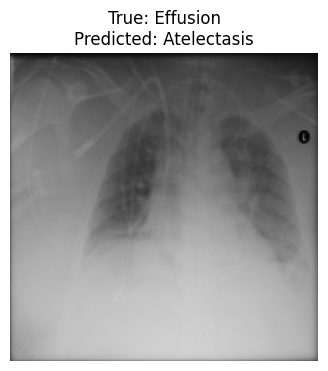

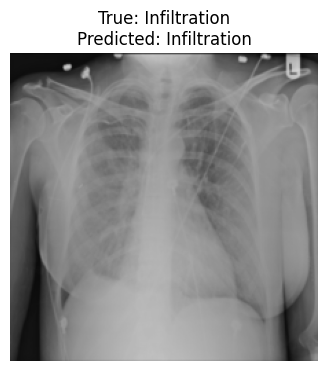

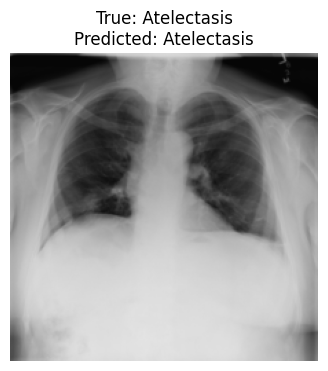

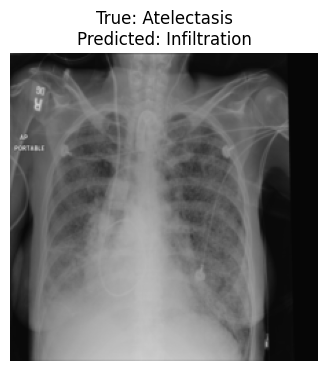

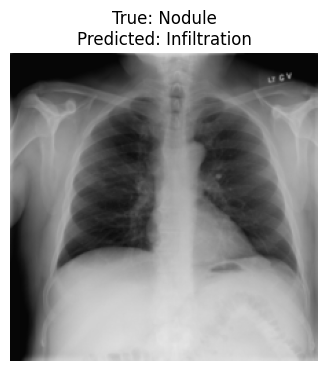

In [119]:
def plot_predictions(model, test_loader, class_names, device, num_images=5):
    model.eval()
    images_shown = 0
    with torch.no_grad():
        for images, labels in test_loader:
            if images_shown >= num_images:
                break  
            
            images, labels = images.to(device), labels.to(device)

            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

           
            images = images.cpu()
            labels = labels.cpu()
            predicted = predicted.cpu()

            for idx in range(images.size(0)):
                if images_shown >= num_images:
                    break
                
                img = images[idx].permute(1, 2, 0).numpy() 
                img = img * 0.229 + 0.485  
                true_label = class_names[labels[idx].item()]
                predicted_label = class_names[predicted[idx].item()]

        
                plt.figure(figsize=(4, 4))
                plt.imshow(img)
                plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
                plt.axis('off')
                plt.show()

                images_shown += 1


plot_predictions(model, test_loader, class_names, device, num_images=5)
